In [2]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pathlib import Path
import scipy
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Urbansurge imports.
from urbansurge import swmm_model, analysis_tools, file_utils
from urbansurge.fault_diagnosis import ann_classifier, ann_regressor, dtw_knn_classifier, quant, cnn_classifier, data_utils
from urbansurge.fault_diagnosis.accuracy_metrics import true_positive_rate

# Autoreload.
%load_ext autoreload
%autoreload 2

In [3]:
# SWMM model configuration file path.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Node where impulse is added.
input_node = 18

# Physical model fault database path.
phy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_impulse_fault_database.csv"

# Simulation model fault database path.
sim_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_impulse_fault_database.csv"

# Physical model with no faults (i.e., "healthy" case)
phy_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_healthy_impulse_database.csv"

# Simulation model with no faults (i.e., "healthy" case)
sim_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_healthy_impulse_database.csv"

# Figure save path.
fig_savefp = Path(r'C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Manuscript\manuscript-v1\Figures')

In [4]:
# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00


In [5]:
# Physical system fault database.
phy_db = pd.read_csv(phy_save_fp)

# Simulation system fault database.
sim_db = pd.read_csv(sim_save_fp)

# Physical healthy system run.
phy_healthy_db = pd.read_csv(phy_healthy_save_fp)

# Simulated healthy system run.
sim_healthy_db = pd.read_csv(sim_healthy_save_fp)

In [6]:
# Depth and velocity columns.
dep_vel_cols = [s for s in sim_healthy_db if any(sub in s for sub in ['Depth_link', 'Velocity'])]

# Select sensors.
links = [20, 21, 23, 45, 44, 43, 42, 41, 40, 39]
skips = [1, 2, 3, 4, 5, 10]

In [7]:
# Fault types.
fault_types = np.unique(sim_db.fault_type)

# Severity density arrays for storing diagnosis accuracy metrics.
severity_density_arrays = {}
severity_dict = {}
for fault_type in fault_types:
    # Severity levels.
    severity_levels = np.unique(sim_db.loc[sim_db.fault_type==fault_type, 'fault_value'])
    severity_dict[fault_type] = severity_levels

    severity_density_ar = np.zeros((len(severity_levels), len(skips)))
    severity_density_arrays[fault_type] = severity_density_ar
    print(severity_density_ar.shape)
    
# Scenarios.
scenarios = np.unique(sim_db.scenario)
scenario_fault_types = [sim_db.loc[sim_db.scenario==scenario, 'fault_type'].iloc[0] for scenario in scenarios]
scenario_fault_types = np.array(scenario_fault_types)
scenario_severities = [sim_db.loc[sim_db.scenario==scenario, 'fault_value'].iloc[0] for scenario in scenarios]
scenario_severities = np.array(scenario_severities)

(15, 6)
(15, 6)
(21, 6)


In [8]:
print(severity_dict['silting'])

[0.1  0.14 0.18 0.22 0.26 0.3  0.34 0.38 0.42 0.46 0.5  0.54 0.58 0.62
 0.66 0.7  0.74 0.78 0.82 0.86 0.9 ]


In [15]:
# Number of hours to retain.
clip_hours = 2

# Noise standard deviation.
noise_std = 0.08

In [16]:
severity_density_ar = np.zeros(())
for skip_idx, skip in enumerate(skips):
    print(skip_idx)
    # Sensor columns.
    sensor_links = links[::skip]
    print(sensor_links)
    dep_cols = [f'Depth_link_{s}' for s in sensor_links]
    vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
    vel_cols = []
    dep_vel_cols = dep_cols + vel_cols

    # Clipped data frames.
    phy_db_clip = data_utils.clip_timeseries(phy_db, clip_hours)
    sim_db_clip = data_utils.clip_timeseries(sim_db, clip_hours)
    phy_healthy_db_clip = data_utils.clip_timeseries(phy_healthy_db, clip_hours, by_scenario=False) 
    sim_healthy_db_clip = data_utils.clip_timeseries(sim_healthy_db, clip_hours, by_scenario=False) 
    
    # Add noise to physical data.
    phy_db_clip[dep_vel_cols] += np.random.normal(0, noise_std, size=phy_db_clip[dep_vel_cols].shape)
    
    # Baseline observations and ensemble from multiple samples.
    n_samples = 5 # Number of times the baseline system is sampled.
    d_obs_baseline, baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, dep_vel_cols, 
                                                                                n_samples, noise_std)
    
    # Residual data frames.
    phy_residual_df = data_utils.compute_residuals(phy_db_clip, baseline_ens_df, dep_vel_cols)
    sim_residual_df = data_utils.compute_residuals(sim_db_clip, sim_healthy_db_clip, dep_vel_cols)
    
    # Normalize residuals.
    phy_residual_norm_df = data_utils.normalize_states(swmm, phy_residual_df, sensor_links, norm_type=None)
    sim_residual_norm_df = data_utils.normalize_states(swmm, sim_residual_df, sensor_links, norm_type=None)
    phy_norm_df = data_utils.normalize_states(swmm, phy_db_clip, sensor_links, norm_type=None)
    sim_norm_df = data_utils.normalize_states(swmm, sim_db_clip, sensor_links, norm_type=None)
    
    # Reshape state variable arrays into 3D arrays where each slice is a separate scenario.
    Xphy_res, yphy_res = data_utils.prepare_states(phy_residual_norm_df, dep_vel_cols)
    Xsim_res, ysim_res = data_utils.prepare_states(sim_residual_norm_df, dep_vel_cols)
    Xphy, yphy = data_utils.prepare_states(phy_norm_df, dep_vel_cols)
    Xsim, ysim = data_utils.prepare_states(sim_norm_df, dep_vel_cols)
    
    # Create tensors to pass into ANN. 
    # 3D array where rows are time steps, columns are depth/velocity sensors, and slices are fault scenarios.
    Xsim_g = Xsim_res.transpose(1, 0, 2).reshape(-1, Xsim.shape[2]).T
    print('N features:', Xsim_g.shape)

    # Labels from simulation model for training.
    # Convert fault class column to categorical values.
    _, ysim_C = np.unique(ysim_res['fault_type'], return_inverse=True)
    
    # Create tensors to pass into ANN.
    Xphy_g = Xphy_res.transpose(1, 0, 2).reshape(-1, Xphy.shape[2]).T
    print('N features:', Xphy_g.shape)

    # Labels from simulation model for training.
    # Convert fault class column to categorical values.
    _, yphy_C = np.unique(yphy_res['fault_type'], return_inverse=True)
    
    #### Fault Classification ####
    # ============================================================================================
    # Train ANN Classifier
    # --------------------------------------------------------
    # Model, loss function, optimizer, and number of epochs.
    input_features = Xsim_g.shape[1]
    output_features = 3
    lr = 0.001
    criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for classification
    num_epochs = 1000  # Set the number of epochs

    # Instantiate model.
    model_C = ann_classifier.ANNClassifier(input_features, output_features, lr, num_epochs, criterion,
                     shuffle_train=True, shuffle_test=False)

    # Train model.
    model_C.fit_model(Xsim_g, ysim_C)
    
    # Test ANN Classifier
    # --------------------------------------------------------
    # Predictions and labels.
    pred_C, label_C = model_C.test_model(Xphy_g, yphy_C)

    # Create categories.
    pred_C = np.argmax(pred_C, axis=1)
    
    for fault_type in fault_types:
        # Severity levels.
        severity_levels = severity_dict[fault_type]
        
        for j, severity_level in enumerate(severity_levels):
            pred_C_sf = pred_C[(scenario_fault_types==fault_type) & (scenario_severities==severity_level)]
            label_C_sf = label_C[(scenario_fault_types==fault_type) & (scenario_severities==severity_level)]
            severity_density_arrays[fault_type][j, skip_idx] = true_positive_rate(pred_C_sf, label_C_sf)
    # ============================================================================================

0
[20, 21, 23, 45, 44, 43, 42, 41, 40, 39]
N features: (246, 1210)
N features: (246, 1210)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91

Epoch: 747
Epoch: 748
Epoch: 749
Epoch: 750
Epoch: 751
Epoch: 752
Epoch: 753
Epoch: 754
Epoch: 755
Epoch: 756
Epoch: 757
Epoch: 758
Epoch: 759
Epoch: 760
Epoch: 761
Epoch: 762
Epoch: 763
Epoch: 764
Epoch: 765
Epoch: 766
Epoch: 767
Epoch: 768
Epoch: 769
Epoch: 770
Epoch: 771
Epoch: 772
Epoch: 773
Epoch: 774
Epoch: 775
Epoch: 776
Epoch: 777
Epoch: 778
Epoch: 779
Epoch: 780
Epoch: 781
Epoch: 782
Epoch: 783
Epoch: 784
Epoch: 785
Epoch: 786
Epoch: 787
Epoch: 788
Epoch: 789
Epoch: 790
Epoch: 791
Epoch: 792
Epoch: 793
Epoch: 794
Epoch: 795
Epoch: 796
Epoch: 797
Epoch: 798
Epoch: 799
Epoch: 800
Epoch: 801
Epoch: 802
Epoch: 803
Epoch: 804
Epoch: 805
Epoch: 806
Epoch: 807
Epoch: 808
Epoch: 809
Epoch: 810
Epoch: 811
Epoch: 812
Epoch: 813
Epoch: 814
Epoch: 815
Epoch: 816
Epoch: 817
Epoch: 818
Epoch: 819
Epoch: 820
Epoch: 821
Epoch: 822
Epoch: 823
Epoch: 824
Epoch: 825
Epoch: 826
Epoch: 827
Epoch: 828
Epoch: 829
Epoch: 830
Epoch: 831
Epoch: 832
Epoch: 833
Epoch: 834
Epoch: 835
Epoch: 836
Epoch: 837

Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 501
Epoch: 502
Epoch: 503
Epoch: 504
Epoch: 505
Epoch: 506
Epoch: 507
Epoch: 508
Epoch: 509
Epoch: 510
Epoch: 511
Epoch: 512
Epoch: 513
Epoch: 514
Epoch: 515
Epoch: 516
Epoch: 517
Epoch: 518
Epoch: 519
Epoch: 520
Epoch: 521
Epoch: 522
Epoch: 523
Epoch: 524
Epoch: 525
Epoch: 526
Epoch: 527
Epoch: 528
Epoch: 529
Epoch: 530
Epoch: 531
Epoch: 532
Epoch: 533
Epoch: 534
Epoch: 535
Epoch: 536
Epoch: 537
Epoch: 538
Epoch: 539
Epoch: 540
Epoch: 541
Epoch: 542
Epoch: 543
Epoch: 544
Epoch: 545
Epoch: 546
Epoch: 547
Epoch: 548
Epoch: 549
Epoch: 550
Epoch: 551
Epoch: 552
Epoch: 553
Epoch: 554
Epoch: 555
Epoch: 556
Epoch: 557
Epoch: 558
Epoch: 559
Epoch: 560
Epoch: 561
Epoch: 562
Epoch: 563
Epoch: 564
Epoch: 565
Epoch: 566
Epoch: 567
Epoch: 568
Epoch: 569
Epoch: 570
Epoch: 571
Epoch: 572
Epoch: 573
Epoch: 574
Epoch: 575
Epoch: 576
Epoch: 577
Epoch: 578
Epoch: 579
Epoch: 580
Epoch: 581
Epoch: 582
Epoch: 583
Epoch: 584

Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331
Epoch: 332
Epoch: 333
Epoch: 334

Epoch: 990
Epoch: 991
Epoch: 992
Epoch: 993
Epoch: 994
Epoch: 995
Epoch: 996
Epoch: 997
Epoch: 998
Epoch: 999
Training finished.
3
[20, 44, 40]
N features: (246, 363)
N features: (246, 363)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81


Epoch: 739
Epoch: 740
Epoch: 741
Epoch: 742
Epoch: 743
Epoch: 744
Epoch: 745
Epoch: 746
Epoch: 747
Epoch: 748
Epoch: 749
Epoch: 750
Epoch: 751
Epoch: 752
Epoch: 753
Epoch: 754
Epoch: 755
Epoch: 756
Epoch: 757
Epoch: 758
Epoch: 759
Epoch: 760
Epoch: 761
Epoch: 762
Epoch: 763
Epoch: 764
Epoch: 765
Epoch: 766
Epoch: 767
Epoch: 768
Epoch: 769
Epoch: 770
Epoch: 771
Epoch: 772
Epoch: 773
Epoch: 774
Epoch: 775
Epoch: 776
Epoch: 777
Epoch: 778
Epoch: 779
Epoch: 780
Epoch: 781
Epoch: 782
Epoch: 783
Epoch: 784
Epoch: 785
Epoch: 786
Epoch: 787
Epoch: 788
Epoch: 789
Epoch: 790
Epoch: 791
Epoch: 792
Epoch: 793
Epoch: 794
Epoch: 795
Epoch: 796
Epoch: 797
Epoch: 798
Epoch: 799
Epoch: 800
Epoch: 801
Epoch: 802
Epoch: 803
Epoch: 804
Epoch: 805
Epoch: 806
Epoch: 807
Epoch: 808
Epoch: 809
Epoch: 810
Epoch: 811
Epoch: 812
Epoch: 813
Epoch: 814
Epoch: 815
Epoch: 816
Epoch: 817
Epoch: 818
Epoch: 819
Epoch: 820
Epoch: 821
Epoch: 822
Epoch: 823
Epoch: 824
Epoch: 825
Epoch: 826
Epoch: 827
Epoch: 828
Epoch: 829

Epoch: 489
Epoch: 490
Epoch: 491
Epoch: 492
Epoch: 493
Epoch: 494
Epoch: 495
Epoch: 496
Epoch: 497
Epoch: 498
Epoch: 499
Epoch: 500
Epoch: 501
Epoch: 502
Epoch: 503
Epoch: 504
Epoch: 505
Epoch: 506
Epoch: 507
Epoch: 508
Epoch: 509
Epoch: 510
Epoch: 511
Epoch: 512
Epoch: 513
Epoch: 514
Epoch: 515
Epoch: 516
Epoch: 517
Epoch: 518
Epoch: 519
Epoch: 520
Epoch: 521
Epoch: 522
Epoch: 523
Epoch: 524
Epoch: 525
Epoch: 526
Epoch: 527
Epoch: 528
Epoch: 529
Epoch: 530
Epoch: 531
Epoch: 532
Epoch: 533
Epoch: 534
Epoch: 535
Epoch: 536
Epoch: 537
Epoch: 538
Epoch: 539
Epoch: 540
Epoch: 541
Epoch: 542
Epoch: 543
Epoch: 544
Epoch: 545
Epoch: 546
Epoch: 547
Epoch: 548
Epoch: 549
Epoch: 550
Epoch: 551
Epoch: 552
Epoch: 553
Epoch: 554
Epoch: 555
Epoch: 556
Epoch: 557
Epoch: 558
Epoch: 559
Epoch: 560
Epoch: 561
Epoch: 562
Epoch: 563
Epoch: 564
Epoch: 565
Epoch: 566
Epoch: 567
Epoch: 568
Epoch: 569
Epoch: 570
Epoch: 571
Epoch: 572
Epoch: 573
Epoch: 574
Epoch: 575
Epoch: 576
Epoch: 577
Epoch: 578
Epoch: 579

Epoch: 241
Epoch: 242
Epoch: 243
Epoch: 244
Epoch: 245
Epoch: 246
Epoch: 247
Epoch: 248
Epoch: 249
Epoch: 250
Epoch: 251
Epoch: 252
Epoch: 253
Epoch: 254
Epoch: 255
Epoch: 256
Epoch: 257
Epoch: 258
Epoch: 259
Epoch: 260
Epoch: 261
Epoch: 262
Epoch: 263
Epoch: 264
Epoch: 265
Epoch: 266
Epoch: 267
Epoch: 268
Epoch: 269
Epoch: 270
Epoch: 271
Epoch: 272
Epoch: 273
Epoch: 274
Epoch: 275
Epoch: 276
Epoch: 277
Epoch: 278
Epoch: 279
Epoch: 280
Epoch: 281
Epoch: 282
Epoch: 283
Epoch: 284
Epoch: 285
Epoch: 286
Epoch: 287
Epoch: 288
Epoch: 289
Epoch: 290
Epoch: 291
Epoch: 292
Epoch: 293
Epoch: 294
Epoch: 295
Epoch: 296
Epoch: 297
Epoch: 298
Epoch: 299
Epoch: 300
Epoch: 301
Epoch: 302
Epoch: 303
Epoch: 304
Epoch: 305
Epoch: 306
Epoch: 307
Epoch: 308
Epoch: 309
Epoch: 310
Epoch: 311
Epoch: 312
Epoch: 313
Epoch: 314
Epoch: 315
Epoch: 316
Epoch: 317
Epoch: 318
Epoch: 319
Epoch: 320
Epoch: 321
Epoch: 322
Epoch: 323
Epoch: 324
Epoch: 325
Epoch: 326
Epoch: 327
Epoch: 328
Epoch: 329
Epoch: 330
Epoch: 331

Epoch: 989
Epoch: 990
Epoch: 991
Epoch: 992
Epoch: 993
Epoch: 994
Epoch: 995
Epoch: 996
Epoch: 997
Epoch: 998
Epoch: 999
Training finished.


[[0.8 0.  0.6 0.4 0.6 0.6]
 [0.6 0.  0.4 0.4 0.  0. ]
 [1.  0.  0.4 0.4 0.2 0.2]
 [1.  0.  0.8 0.6 0.2 0. ]
 [1.  0.2 0.8 0.4 0.6 0. ]
 [1.  0.2 0.8 0.2 0.6 0.4]
 [1.  0.4 0.8 0.4 0.4 0.2]
 [1.  0.4 0.8 0.4 0.2 0. ]
 [1.  0.2 0.8 0.4 0.6 0.2]
 [1.  0.4 0.8 0.2 0.2 0.2]
 [1.  0.8 1.  0.6 1.  0.4]
 [1.  0.8 0.8 0.8 0.6 0.4]
 [1.  1.  1.  1.  1.  0.2]
 [1.  0.8 1.  1.  0.8 0.4]
 [1.  1.  1.  1.  1.  0.8]]
Total Length = 2275.0 ft
[[1.  0.9 0.8 0.9 0.8 0.9]
 [1.  0.8 0.7 0.8 0.7 0.7]
 [1.  1.  0.8 1.  0.9 0.9]
 [1.  1.  0.8 0.9 0.9 0.8]
 [1.  1.  0.9 0.8 1.  1. ]
 [1.  1.  0.9 1.  1.  0.9]
 [1.  1.  1.  0.8 1.  0.9]
 [1.  1.  1.  0.9 0.9 0.9]
 [1.  1.  0.9 0.9 0.8 1. ]
 [1.  1.  1.  0.9 1.  0.9]
 [1.  1.  0.9 1.  1.  1. ]
 [1.  1.  0.9 0.8 1.  1. ]
 [1.  0.9 0.9 0.9 1.  1. ]
 [1.  0.9 1.  0.8 1.  1. ]
 [1.  0.9 0.8 1.  1.  1. ]]
Total Length = 2275.0 ft
[[0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 1.]
 [1. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1

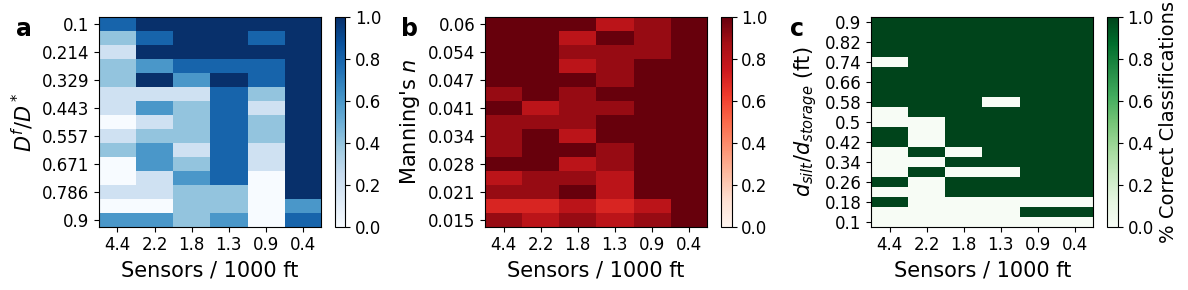

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
for i, fault_type in enumerate(fault_types):
    # Fault type to plot.
#     fault_type = 'roughness'

    # Colormap names.
    if fault_type == 'diameter':
        cmap_name = 'Blues'
        ylabel = '$D^f / D^*$'
        severities = severity_dict[fault_type][::-1]
        yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
    elif fault_type == 'roughness':
        cmap_name = 'Reds'
        ylabel = "Manning's $n$"
        severities = severity_dict[fault_type] * 0.01 
        yticks = np.linspace(0.015, 0.06, 4)
    elif fault_type == 'silting':
        cmap_name = 'Greens'
        ylabel = '$d_{silt} / d_{storage}$ (ft)'
        severities = severity_dict[fault_type]
        yticks = [0.1, 0.3, 0.5, 0.7, 0.9]

    # Plotting array.
    plotting_ar = severity_density_arrays[fault_type]
    nrow, ncol = plotting_ar.shape
    print(plotting_ar)

    # Total length of flow path.
    total_length = swmm.upstream_distance(20, 'Link', 18, 'Junction')
    print(f'Total Length = {total_length} ft')

    # Number of sensors at each density.
    n_sensors = [10, 5, 4, 3, 2, 1]

    # Sensors / distance.
    dist = 1000
    sensors_per_dist = n_sensors / total_length * dist

#     fig, ax = plt.subplots()
    ax = axes[i]
    cf = ax.imshow(np.fliplr(plotting_ar), cmap=cmap_name, origin='lower', aspect='auto', vmin=0, vmax=1)
    cbar = fig.colorbar(cf, ax=ax)
    if i == 2:
        cbar.set_label('% Correct Classifications', fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlabel(f'Sensors / {dist} ft', fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    # X-ticks.
    xtick_idx = np.arange(0, ncol, 1)
    ax.set_xticks(xtick_idx)
    ax.set_xticklabels(np.round(sensors_per_dist, 1))
    # Y-ticks.
    ytick_idx = np.arange(0, nrow, 2)
    ax.set_yticks(ytick_idx)
    ax.set_yticklabels(np.round(severities[ytick_idx], 3))
    
    # Add subfigure letter.
    halign=1
    subplot_labels = ['a', 'b', 'c']
    ax.text(-0.3, halign, subplot_labels[i],
        transform=ax.transAxes,  # Coordinates relative to the axis (0,0) to (1,1)
        fontsize=17,             # Font size
        verticalalignment='top', # Align text to the top
        horizontalalignment='right',  # Align text to the right
        weight='bold')
    
fig.tight_layout()
fig.savefig(fig_savefp / 'classification_accuracy.png', dpi=300)